In [1]:
import numpy as np
import pints
import pints.plot
import pints_smol_moments_4_normalised_jit_surface_area_pro as toy
import matplotlib.pyplot as plt
from scipy.stats import moment
import pandas as pd



Select the desired model, true parameters and time array.

Then simulate to get synthetic data

In [2]:

model = toy.SmolModel(None,None)


true_parameters = [0.0003, 0.01, 900]


times = np.linspace(20, 75, 56)

df = pd.read_csv('2017-03-16_inference_input_multi_well_t_20.csv', header=None)
org_values = np.transpose(df.to_numpy())
org_values = org_values[:56,:]


# 1st moment is mean, 1st centred moment should be array 6
centred_moment_1 = moment(org_values, moment=1, axis=1)
centred_moment_2 = moment(org_values, moment=2, axis=1)
centred_moment_3 = moment(org_values, moment=3, axis=1)
centred_moment_4 = moment(org_values, moment=4, axis=1)

# Out array, mean, variance then centred standardised moments (aka skewness, kurtosis, hyperskewness)
st_dev = np.sqrt(centred_moment_2)
out_array = np.zeros((56,4))
out_array[:,0] = np.mean(org_values,axis=1)
out_array[:,1] = centred_moment_2
out_array[:,2] = np.divide(centred_moment_3,st_dev*st_dev*st_dev)
out_array[:,3] = np.divide(centred_moment_4,st_dev*st_dev*st_dev*st_dev)

# print(st_dev)

# print(np.mean(org_values, axis=1))
# print(centred_moment_3)



Add noise to the data (using random sampling from normal distribution)

In [3]:

# noise = 9
# values = org_values + np.random.normal(0, noise, org_values.shape)

size_noise = 4
noise_value = 1
# # Create a list with the specified size filled with a placeholder value
noise_arr = [noise_value for _ in range(size_noise)]
# noise_arr[0] = 1
# noise_arr[1] = 1
# noise_arr[2] = 1
# noise_arr[3] = 1


Set-up pints problem and log likelihoods

In [4]:

# problem = pints.MultiOutputProblem(model, times, centred_moments)
problem = pints.MultiOutputProblem(model, times, out_array)

log_likelihood = pints.GaussianLogLikelihood(problem)
# log_likelihood_2 = pints.GaussianIntegratedLogUniformLogLikelihood(problem)

print('Original problem dimension: ' + str(problem.n_parameters()))
print('New dimension: ' + str(log_likelihood.n_parameters()))
# print('New dimension: ' + str(log_likelihood_2.n_parameters()))

true_parameters += noise_arr
# print(true_parameters)



Original problem dimension: 3
New dimension: 7


Create uniform log prior

In [5]:

# Define the size of the list
size = 7
placeholder_lower_value = 0
placeholder_upper_value = 1000
 
# Create a list with the specified size filled with a placeholder value
prior_arr_lower = [placeholder_lower_value for _ in range(size)]
prior_arr_upper = [placeholder_upper_value for _ in range(size)]
prior_arr_lower[0] = 0.00001
prior_arr_upper[0] = 0.001
prior_arr_lower[1] = 0.00001
prior_arr_upper[1] = 0.1
prior_arr_lower[2] = 1
prior_arr_upper[2] = 4000
prior_arr_lower[3] = 0
prior_arr_upper[3] = 100
prior_arr_lower[4] = 0
prior_arr_upper[4] = 100
prior_arr_lower[5] = 0
prior_arr_upper[5] = 100
prior_arr_lower[6] = 0
prior_arr_upper[6] = 100


# log_prior = pints.UniformLogPrior(
#     [0.000001, 1, 1],
#     [0.01, 10000, 100]
#     )
log_prior = pints.UniformLogPrior(
    prior_arr_lower,
    prior_arr_upper
    )

# Create a posterior log-likelihood (log(likelihood * prior))
log_posterior = pints.LogPosterior(log_likelihood, log_prior)


/var/folders/lt/9g_w308946v4x_5mqxc951qr0000gr/T/ipykernel_4152/3449605926.py:29: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  log_prior = pints.UniformLogPrior(


In [6]:

xs = [
    np.array(true_parameters) * 0.9,
    np.array(true_parameters) * 1.05,
    np.array(true_parameters) * 1.15,
]
ITERS = 1000
mcmc = pints.MCMCController(log_posterior, 3, xs, method=pints.SliceDoublingMCMC)
mcmc.set_max_iterations(ITERS)
chains = mcmc.run()
print(chains)



Using Slice Sampling - Doubling
Generating 3 chains.
Running in sequential mode.
Iter. Eval. Time m:s
0     3       0:00.3
1     507     0:10.5
2     1008    0:12.5
3     1491    0:13.8
 lsoda--  at t(=r1) and step size h(=r2), the error  
       test failed repeatedly or with abs(h) = hmin  
      in above,  r1 =  0.5413440377341D+02   r2 =  0.9036832901861D-12


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/integrate/_odepack_py.py:248: ODEintWarning: Repeated error test failures (internal error). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


20    8220    0:44.0
40    13674   0:56.7
60    18726   1:08.1
80    24495   1:22.8
100   29700   1:34.5
120   35202   1:48.0
140   40575   2:00.3
160   46008   2:13.0
180   51357   2:25.2
200   56676   2:37.1
220   62403   2:49.7
240   67746   3:01.7
260   73290   3:15.0
280   78657   3:26.9
300   84015   3:38.7
 lsoda--  at t(=r1) and step size h(=r2), the error  
       test failed repeatedly or with abs(h) = hmin  
      in above,  r1 =  0.6567972953833D+02   r2 =  0.1134410184625D-11
 lsoda--  at t(=r1) and step size h(=r2), the error  
       test failed repeatedly or with abs(h) = hmin  
      in above,  r1 =  0.4257563105311D+02   r2 =  0.2709712574774D-10
320   89421   3:54.5
340   94482   4:06.1
360   99870   4:18.8
 lsoda--  at t(=r1) and step size h(=r2), the error  
       test failed repeatedly or with abs(h) = hmin  
      in above,  r1 =  0.6177401294645D+02   r2 =  0.9187147961646D-10
380   105489   4:34.6
400   110688   4:46.7
420   116190   4:59.2
440   121560   5:12

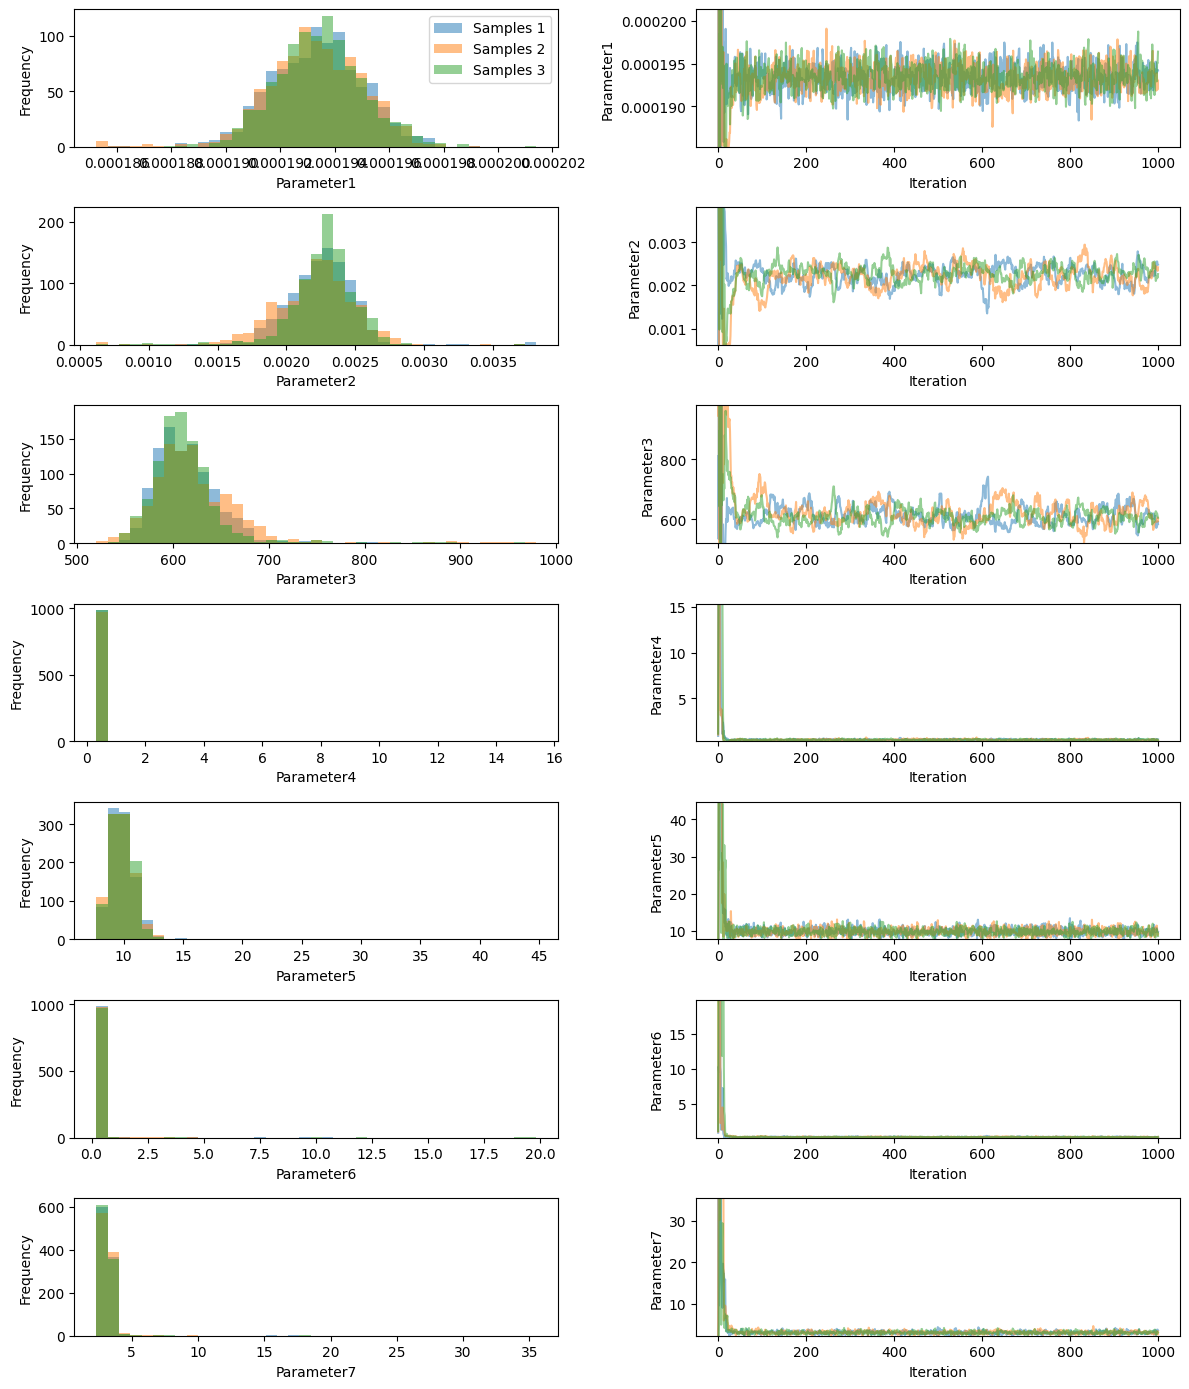

In [7]:

pints.plot.trace(chains, n_percentiles=99)
plt.savefig("mcmc.png")
plt.show()


In [8]:

y0 = np.array([0.0003, 0.01, 900,6,6,6,6])

boundaries_3d = pints.RectangularBoundaries(prior_arr_lower,
    prior_arr_upper)

opt = pints.OptimisationController(log_likelihood, y0, boundaries=boundaries_3d, method=pints.XNES)
opt.set_log_to_screen(False)
y1, g1 = opt.run()
print('Estimated parameters:')
print(y1)

y0 = np.array([0.0001, 0.01, 900,6,6,6,6])

boundaries_3d = pints.RectangularBoundaries(prior_arr_lower,
    prior_arr_upper)

opt = pints.OptimisationController(log_likelihood, y0, boundaries=boundaries_3d, method=pints.XNES)
opt.set_log_to_screen(False)
y1, g1 = opt.run()
print('Estimated parameters:')
print(y1)

y0 = np.array([0.0003, 0.001, 900,6,6,6,6])

boundaries_3d = pints.RectangularBoundaries(prior_arr_lower,
    prior_arr_upper)

opt = pints.OptimisationController(log_likelihood, y0, boundaries=boundaries_3d, method=pints.XNES)
opt.set_log_to_screen(False)
y1, g1 = opt.run()
print('Estimated parameters:')
print(y1)

y0 = np.array([0.0003, 0.01, 500,6,6,6,6])

boundaries_3d = pints.RectangularBoundaries(prior_arr_lower,
    prior_arr_upper)

opt = pints.OptimisationController(log_likelihood, y0, boundaries=boundaries_3d, method=pints.XNES)
opt.set_log_to_screen(False)
y1, g1 = opt.run()
print('Estimated parameters:')
print(y1)

y0 = np.array([0.0001, 0.001, 900,6,6,6,6])

boundaries_3d = pints.RectangularBoundaries(prior_arr_lower,
    prior_arr_upper)

opt = pints.OptimisationController(log_likelihood, y0, boundaries=boundaries_3d, method=pints.XNES)
opt.set_log_to_screen(False)
y1, g1 = opt.run()
print('Estimated parameters:')
print(y1)

y0 = np.array([0.0001, 0.01, 500,6,6,6,6])

boundaries_3d = pints.RectangularBoundaries(prior_arr_lower,
    prior_arr_upper)

opt = pints.OptimisationController(log_likelihood, y0, boundaries=boundaries_3d, method=pints.XNES)
opt.set_log_to_screen(False)
y1, g1 = opt.run()
print('Estimated parameters:')
print(y1)

y0 = np.array([0.0003, 0.001, 500,6,6,6,6])

boundaries_3d = pints.RectangularBoundaries(prior_arr_lower,
    prior_arr_upper)

opt = pints.OptimisationController(log_likelihood, y0, boundaries=boundaries_3d, method=pints.XNES)
opt.set_log_to_screen(False)
y1, g1 = opt.run()
print('Estimated parameters:')
print(y1)

y0 = np.array([0.0001, 0.001, 500,6,6,6,6])

boundaries_3d = pints.RectangularBoundaries(prior_arr_lower,
    prior_arr_upper)

opt = pints.OptimisationController(log_likelihood, y0, boundaries=boundaries_3d, method=pints.XNES)
opt.set_log_to_screen(False)
y1, g1 = opt.run()
print('Estimated parameters:')
print(y1)


Estimated parameters:
[1.93461272e-04 2.29649206e-03 6.05125596e+02 4.72856408e-01
 9.49223089e+00 2.78896044e-01 2.98566114e+00]


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pints/_optimisers/_xnes.py:82: UserWarning: All points requested by XNES are outside the boundaries.
  warnings.warn(


Estimated parameters:
[1.93461273e-04 2.29649211e-03 6.05125585e+02 4.72856394e-01
 9.49223088e+00 2.78896033e-01 2.98566128e+00]
Estimated parameters:
[2.58156849e-05 1.26856951e-02 1.94880970e+03 5.21991655e+00
 8.59766242e+00 4.74027505e-01 3.76780068e+00]
Estimated parameters:
[1.93461272e-04 2.29649201e-03 6.05125601e+02 4.72856394e-01
 9.49223095e+00 2.78896043e-01 2.98566128e+00]
Estimated parameters:
[1.93461272e-04 2.29649207e-03 6.05125600e+02 4.72856398e-01
 9.49223070e+00 2.78896035e-01 2.98566130e+00]
Estimated parameters:
[1.93461272e-04 2.29649204e-03 6.05125601e+02 4.72856393e-01
 9.49223096e+00 2.78896047e-01 2.98566131e+00]
Estimated parameters:
[1.93461271e-04 2.29649198e-03 6.05125609e+02 4.72856379e-01
 9.49223099e+00 2.78896035e-01 2.98566130e+00]
Estimated parameters:
[1.93461271e-04 2.29649209e-03 6.05125598e+02 4.72856390e-01
 9.49223102e+00 2.78896036e-01 2.98566132e+00]


In [9]:
print(log_likelihood([1.93461272e-04, 2.29649206e-03, 6.05125596e+02, 4.72856408e-01,
 9.49223089e+00, 2.78896044e-01, 2.98566114e+00]))

AIC = 2*7 - 2*log_likelihood([1.93461272e-04, 2.29649206e-03, 6.05125596e+02, 4.72856408e-01,
 9.49223089e+00, 2.78896044e-01, 2.98566114e+00])

print(AIC)

-391.6734823939103
797.3469647878206


In [10]:

# ITERS = 100
AllChains = chains[0,100:10000,:]
# np.asarray(AllChains)
print(np.shape(AllChains))
print(AllChains[0])
print(AllChains)


(900, 7)
[1.94178721e-04 2.30906114e-03 5.96184010e+02 4.62515557e-01
 8.20057673e+00 2.70082848e-01 2.78357629e+00]
[[1.94178721e-04 2.30906114e-03 5.96184010e+02 ... 8.20057673e+00
  2.70082848e-01 2.78357629e+00]
 [1.93463571e-04 2.39870814e-03 5.95719925e+02 ... 1.08499010e+01
  2.57773642e-01 2.99239999e+00]
 [1.94277480e-04 2.28511942e-03 5.99621813e+02 ... 9.09360512e+00
  3.32422100e-01 2.69981123e+00]
 ...
 [1.94017665e-04 2.55505845e-03 5.77282132e+02 ... 1.00460790e+01
  2.68961128e-01 3.78908349e+00]
 [1.94196065e-04 2.49536475e-03 5.92450053e+02 ... 9.79492079e+00
  2.76887560e-01 3.80264818e+00]
 [1.94208170e-04 2.47932013e-03 5.83146369e+02 ... 9.75164337e+00
  2.59564968e-01 3.59801426e+00]]


In [11]:

for I in range(3-1):
    AllChains_add = chains[I+1,100:10000,:]
    AllChains = np.concatenate((AllChains,AllChains_add), axis=0)


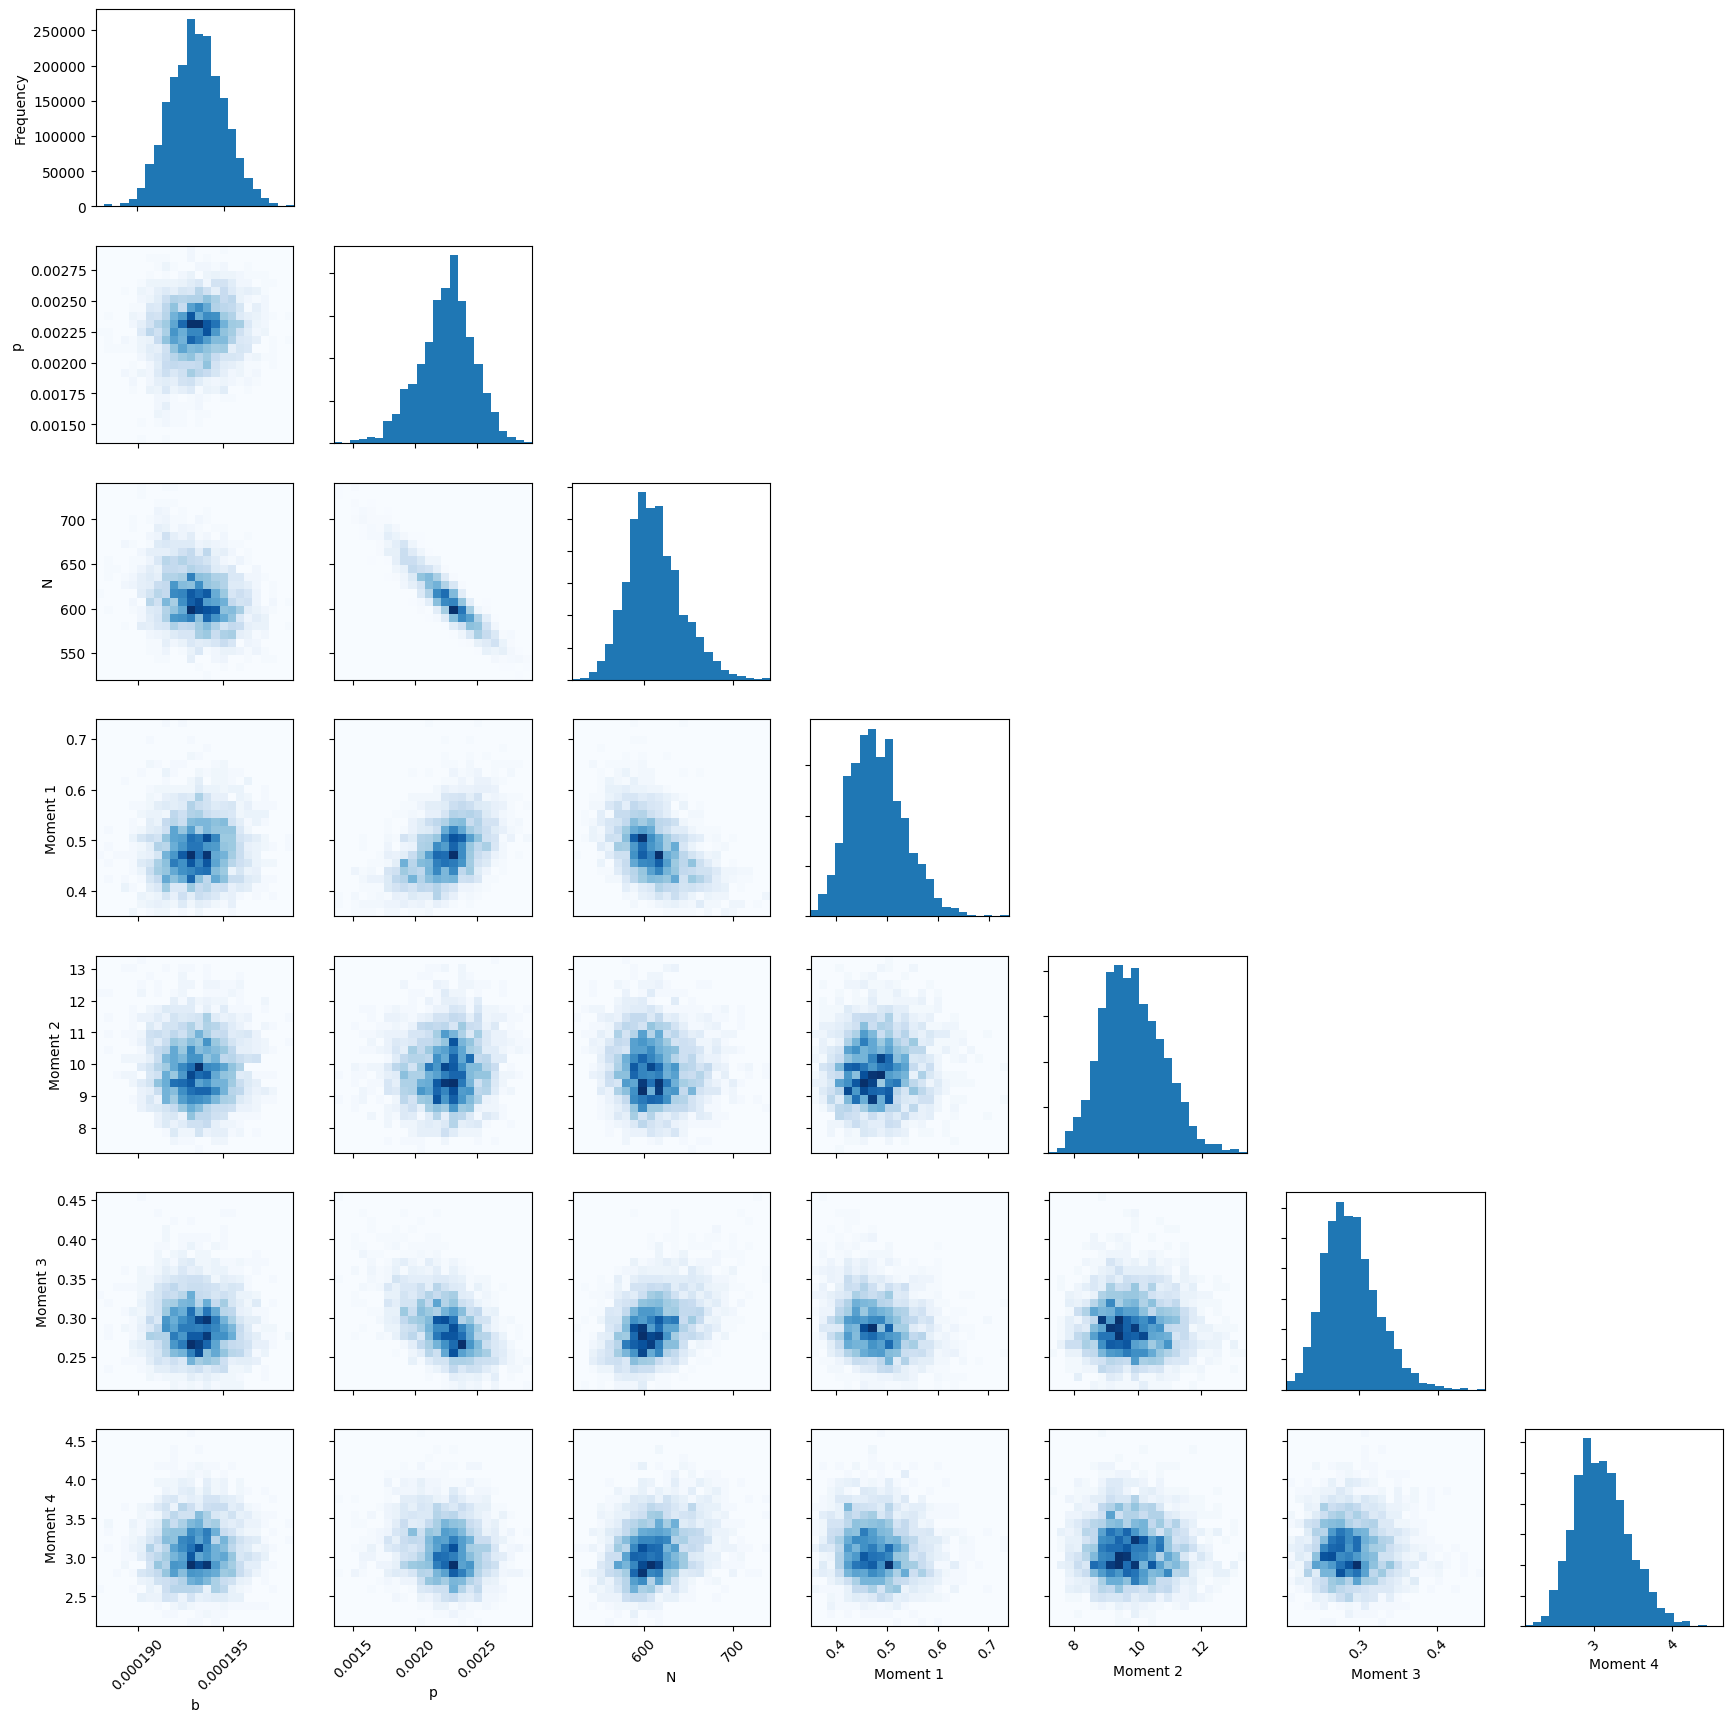

In [12]:


parameter_names = ["b","p", "N", "Moment 1", "Moment 2", "Moment 3", "Moment 4"]
#pints.plot.pairwise(chains, kde=True, parameter_names=parameter_names)

pints.plot.pairwise(AllChains, heatmap=True, 
                    parameter_names=["b","p", "N", "Moment 1", "Moment 2", "Moment 3", "Moment 4"])
plt.show()

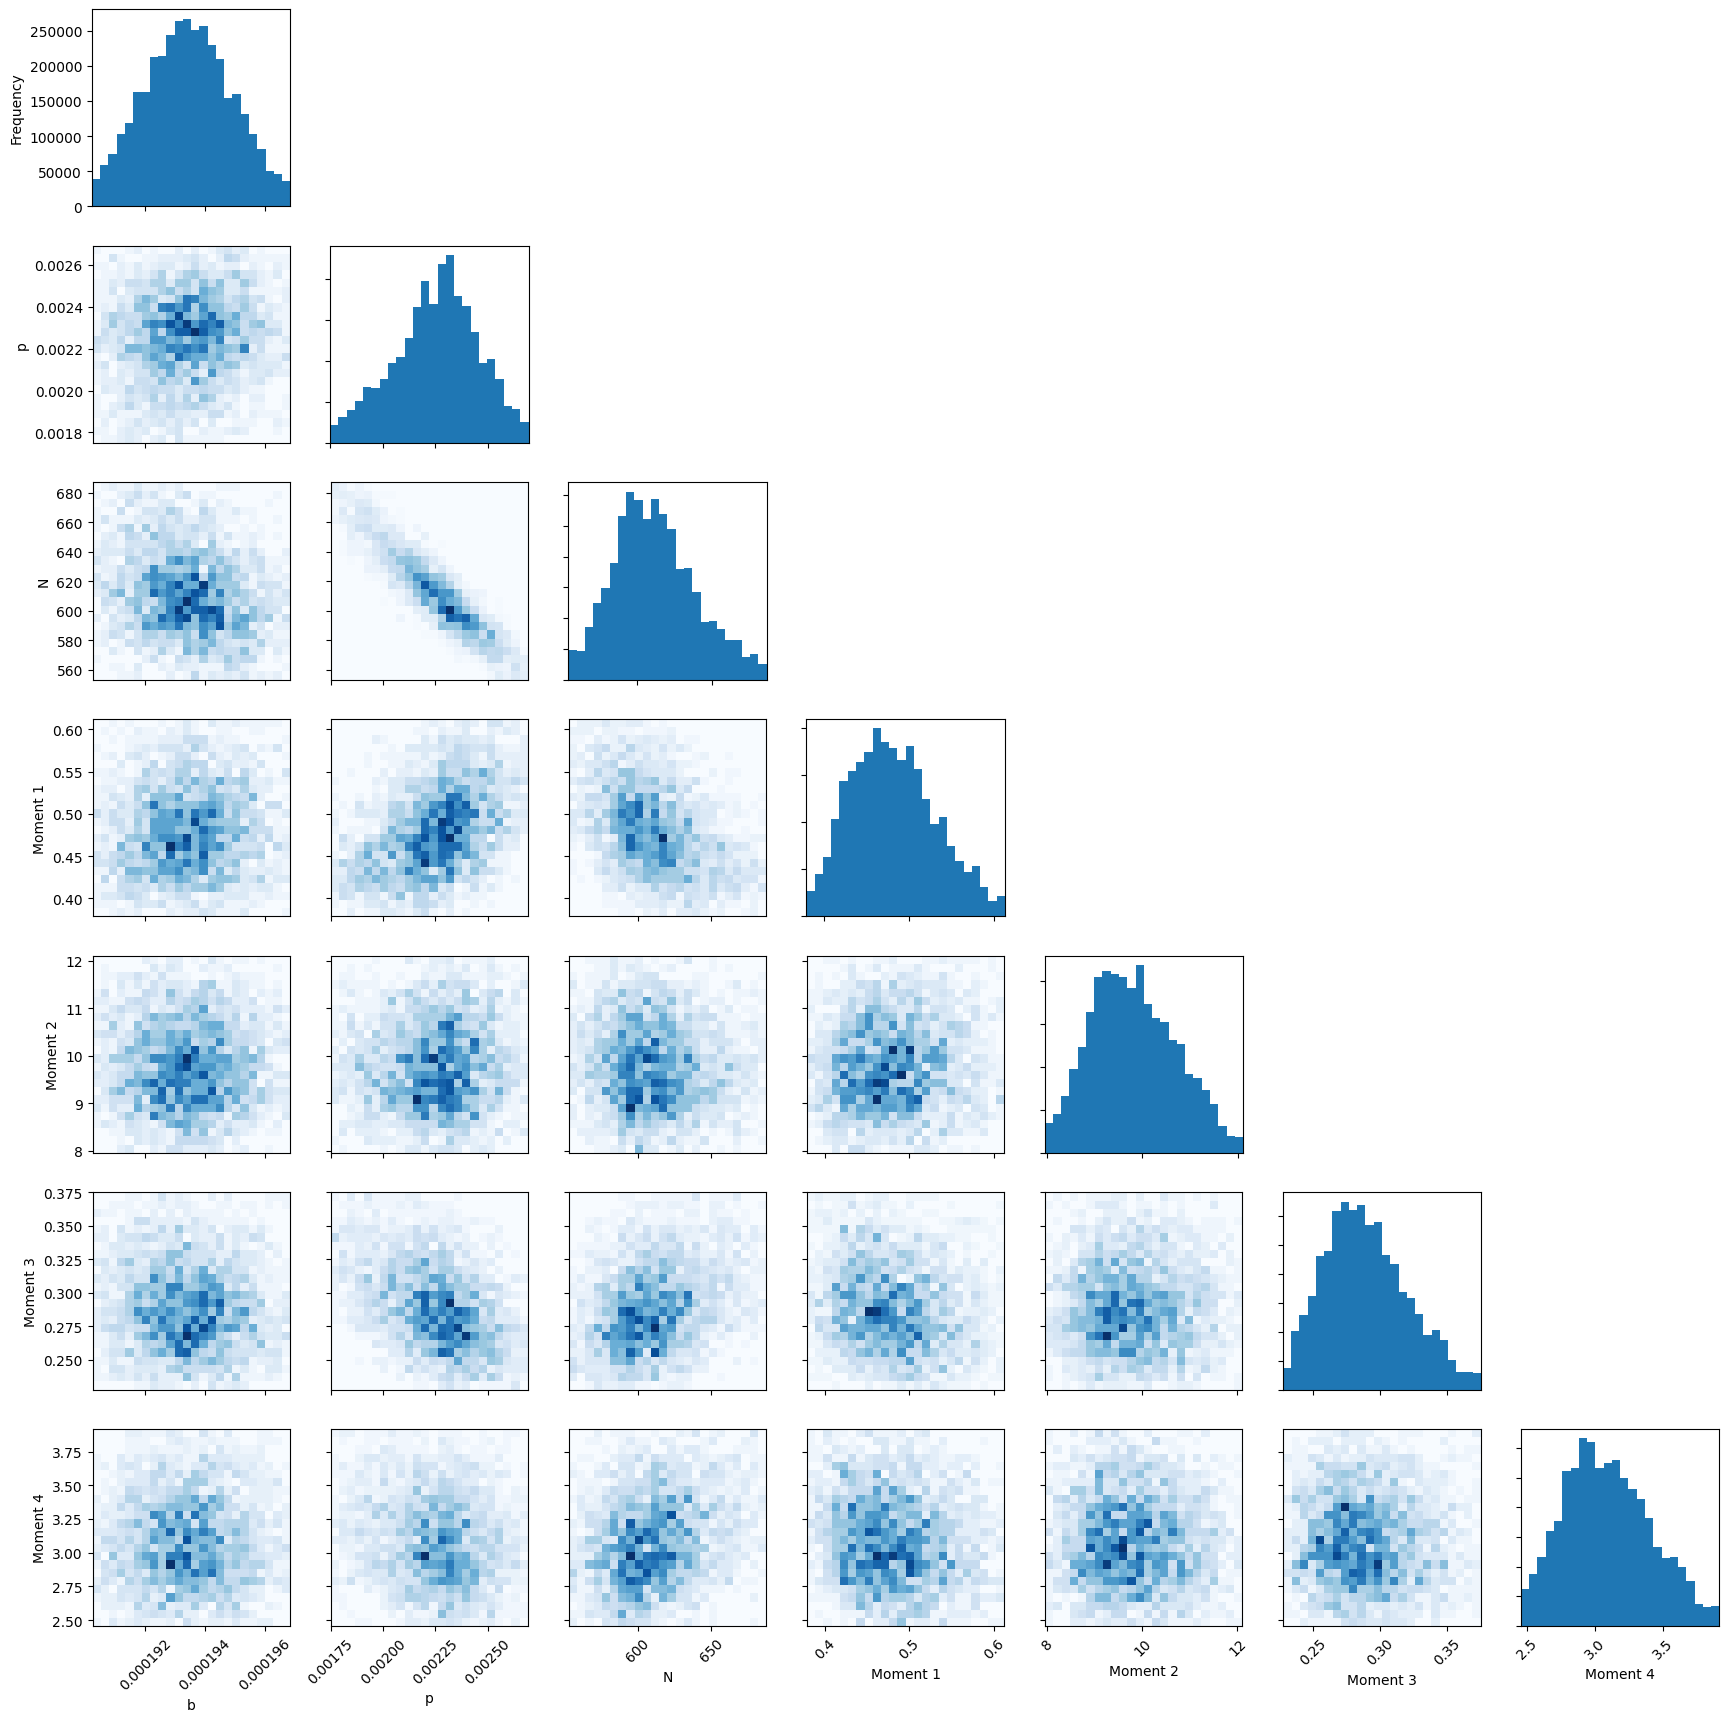

In [13]:
parameter_names = ["b","p","N", "Moment 1", "Moment 2", "Moment 3", "Moment 4"]
#pints.plot.pairwise(chains, kde=True, parameter_names=parameter_names)

pints.plot.pairwise(AllChains, heatmap=True, 
                    parameter_names=["b","p","N", "Moment 1", "Moment 2", "Moment 3", "Moment 4"],
                    n_percentiles=97)
                    
plt.show()

In [14]:
parameter_names = ["b","p","N", "Moment 1", "Moment 2", "Moment 3", "Moment 4"]
results = pints.MCMCSummary(chains=chains[:,int(ITERS/2):, :], time=mcmc.time(),
                            parameter_names = parameter_names)
print(type(results))
print(results)


<class 'pints._mcmc._summary.MCMCSummary'>
param     mean    std.    2.5%    25%     50%     75%     97.5%    rhat    ess     ess per sec.
--------  ------  ------  ------  ------  ------  ------  -------  ------  ------  --------------
b         0.00    0.00    0.00    0.00    0.00    0.00    0.00     1.00    312.11  0.49
p         0.00    0.00    0.00    0.00    0.00    0.00    0.00     1.01    85.17   0.13
N         611.12  31.51   557.37  589.41  608.62  630.01  680.77   1.02    83.99   0.13
Moment 1  0.48    0.05    0.39    0.44    0.48    0.52    0.59     1.00    230.87  0.36
Moment 2  9.83    0.96    8.18    9.12    9.73    10.51   11.75    1.00    457.18  0.71
Moment 3  0.29    0.03    0.23    0.27    0.29    0.31    0.36     1.00    219.78  0.34
Moment 4  3.10    0.35    2.50    2.84    3.06    3.31    3.87     1.00    349.60  0.55


In [15]:
from tabulate import tabulate
class MyMCMCSummary(pints.MCMCSummary):
    def __str__(self):
        """
        Prints posterior summaries for all parameters to the console, including
        the parameter name, posterior mean, posterior std deviation, the
        2.5%, 25%, 50%, 75% and 97.5% posterior quantiles, rhat, effective
        sample size (ess) and ess per second of run time.
        """
        if self._summary_str is None:
            headers = [
                'param', 'mean', 'std.',
                '2.5%', '25%', '50%', '75%', '97.5%',
                'rhat', 'ess']
            if self._time is not None:
                headers.append('ess per sec.')

            self._summary_str = tabulate(
                self._summary_list,
                headers=headers,
                numalign='left',
                floatfmt='.3g',
            )

        return self._summary_str
    


In [16]:

parameter_names = ["b","p","N", "Moment 1", "Moment 2", "Moment 3", "Moment 4"]
results = MyMCMCSummary(chains=chains[:,int(ITERS/2):, :], time=mcmc.time(),
                            parameter_names = parameter_names)
print(type(results))
print(results)

<class '__main__.MyMCMCSummary'>
param     mean      std.      2.5%      25%       50%       75%       97.5%     rhat    ess    ess per sec.
--------  --------  --------  --------  --------  --------  --------  --------  ------  -----  --------------
b         0.000193  1.58e-06  0.000191  0.000192  0.000193  0.000195  0.000197  1       312    0.487
p         0.00226   0.000225  0.00179   0.00212   0.00228   0.00241   0.00266   1.01    85.2   0.133
N         611       31.5      557       589       609       630       681       1.02    84     0.131
Moment 1  0.484     0.0543    0.389     0.444     0.481     0.519     0.592     1       231    0.36
Moment 2  9.83      0.959     8.18      9.12      9.73      10.5      11.8      0.998   457    0.713
Moment 3  0.29      0.0333    0.233     0.267     0.286     0.309     0.363     1       220    0.343
Moment 4  3.1       0.351     2.5       2.84      3.06      3.31      3.87      1       350    0.545


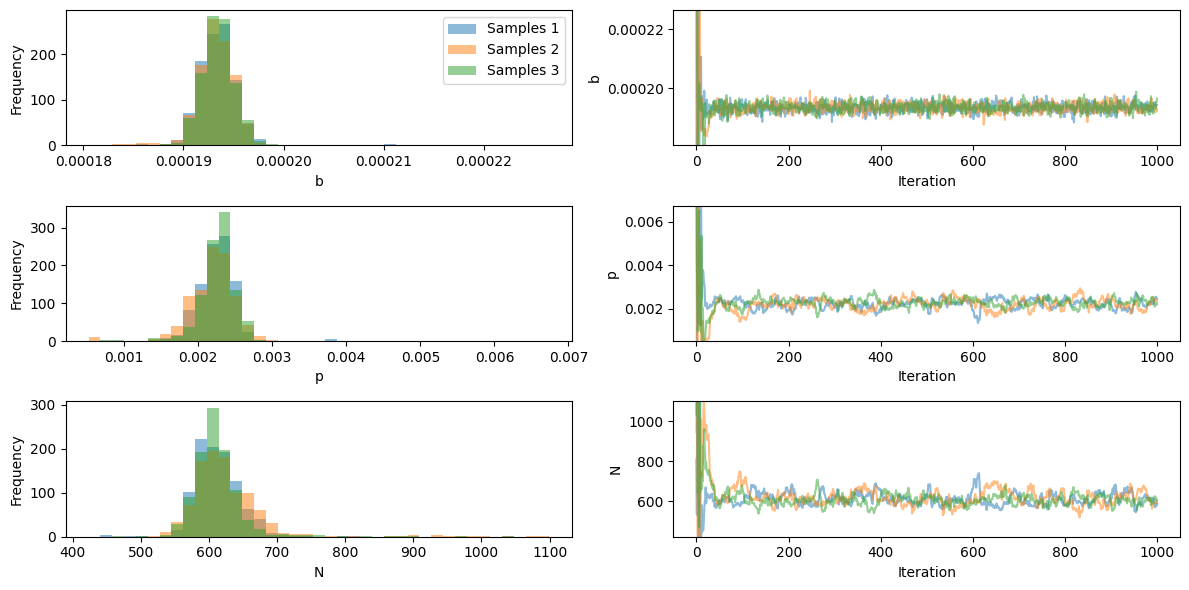

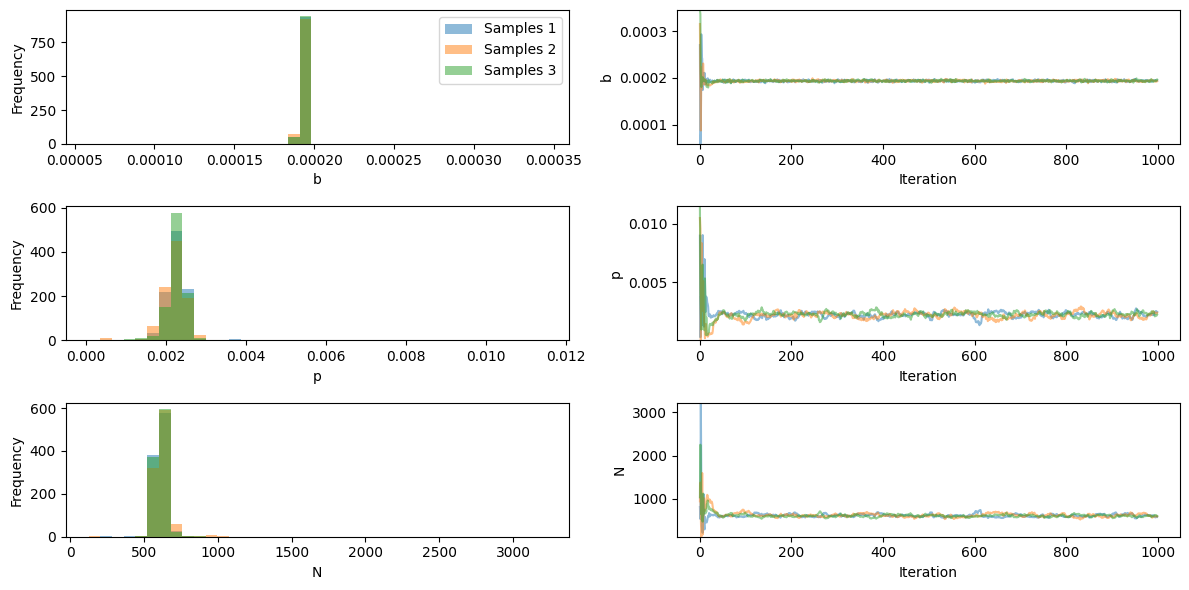

In [17]:
pints.plot.trace(chains[:,:,[0,1,2]], n_percentiles=99.5, parameter_names=["b","p","N"])
plt.savefig("pints_out_extremes_removed.png", dpi=300)
plt.show()
pints.plot.trace(chains[:,:,[0,1,2]], parameter_names=["b","p","N"])
plt.savefig("pints_out.png", dpi=300)
plt.show()

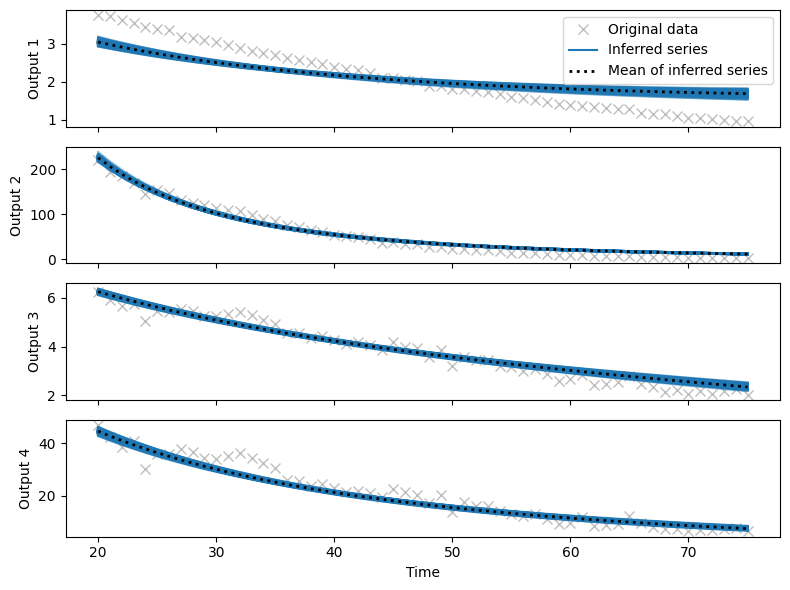

In [18]:
fig, axes = pints.plot.series(AllChains, problem)

# # Customise the plot, and add the original, noise-free data
# fig.set_size_inches(12,4.5)
# plt.plot(times, org_values, c='orange', label='Noise-free data')
# plt.legend()
# plt.show()

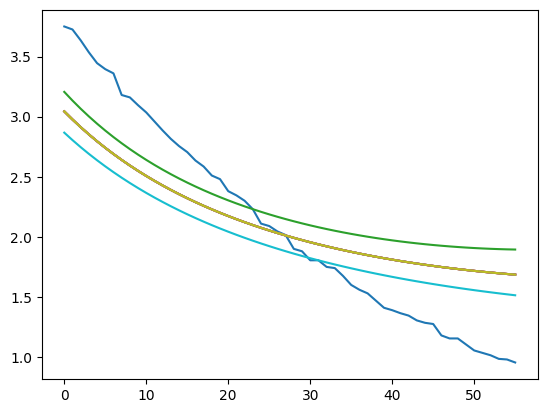

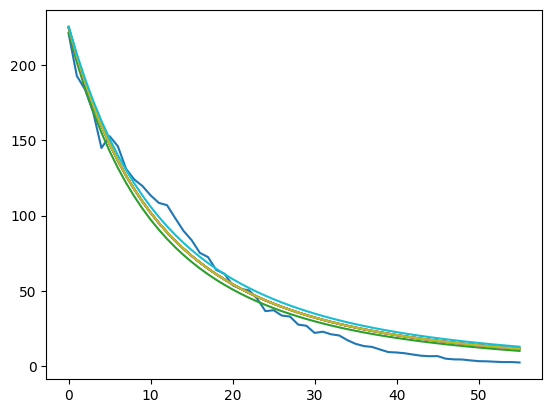

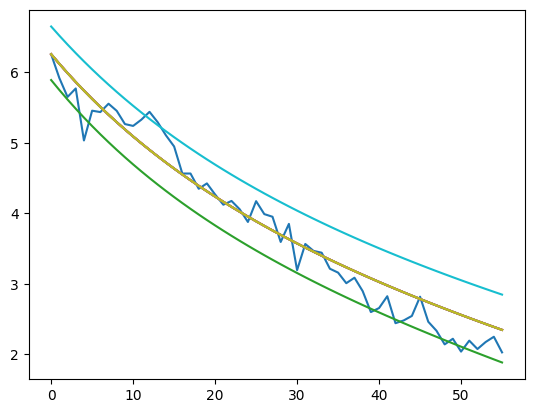

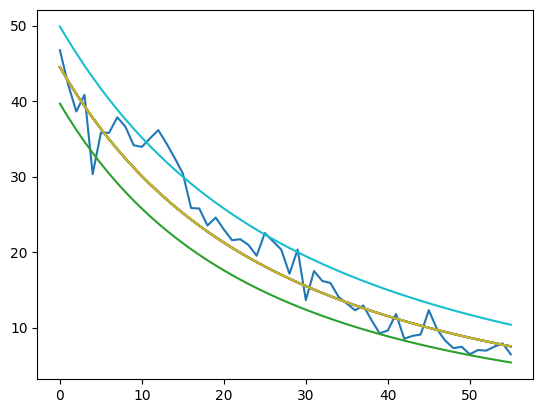

In [19]:


data_mean = out_array[:,0]
data_variance = out_array[:,1]
data_skewness = out_array[:,2]
data_kurtosis = out_array[:,3]

# for i in range(1000):
means = results.mean()[[0,1,2]]
st_devs = results.std()[[0,1,2]]

CI_0 = means

CI_1 = means + 2*st_devs

CI_2 = means
CI_2[0] += 2*st_devs[0]
CI_2[1] += 2*st_devs[1] 
CI_2[2] -= 2*st_devs[2]

CI_3 = means
CI_3[0] += 2*st_devs[0]
CI_3[1] -= 2*st_devs[1] 
CI_3[2] += 2*st_devs[2]

CI_4 = means
CI_4[0] -= 2*st_devs[0]
CI_4[1] += 2*st_devs[1] 
CI_4[2] += 2*st_devs[2]

CI_5 = means
CI_5[0] += 2*st_devs[0]
CI_5[1] -= 2*st_devs[1] 
CI_5[2] -= 2*st_devs[2]

CI_6 = means
CI_6[0] -= 2*st_devs[0]
CI_6[1] += 2*st_devs[1] 
CI_6[2] -= 2*st_devs[2]

CI_7 = means
CI_7[0] -= 2*st_devs[0]
CI_7[1] -= 2*st_devs[1] 
CI_7[2] += 2*st_devs[2] 

CI_8 = means - 2*st_devs

values_0 = model.simulate(CI_0, times)
values_1 = model.simulate(CI_1, times)
values_2 = model.simulate(CI_2, times)
values_3 = model.simulate(CI_3, times)
values_4 = model.simulate(CI_4, times)
values_5 = model.simulate(CI_5, times)
values_6 = model.simulate(CI_6, times)
values_7 = model.simulate(CI_7, times)
values_8 = model.simulate(CI_8, times)
# print(np.shape(values))

plt.plot(data_mean)
plt.plot(values_0[:,0])
plt.plot(values_1[:,0])
plt.plot(values_2[:,0])
plt.plot(values_3[:,0])
plt.plot(values_4[:,0])
plt.plot(values_5[:,0])
plt.plot(values_6[:,0])
plt.plot(values_7[:,0])
plt.plot(values_8[:,0])
plt.show()



plt.plot(data_variance)
plt.plot(values_0[:,1])
plt.plot(values_1[:,1])
plt.plot(values_2[:,1])
plt.plot(values_3[:,1])
plt.plot(values_4[:,1])
plt.plot(values_5[:,1])
plt.plot(values_6[:,1])
plt.plot(values_7[:,1])
plt.plot(values_8[:,1])
plt.show()


plt.plot(data_skewness)
plt.plot(values_0[:,2])
plt.plot(values_1[:,2])
plt.plot(values_2[:,2])
plt.plot(values_3[:,2])
plt.plot(values_4[:,2])
plt.plot(values_5[:,2])
plt.plot(values_6[:,2])
plt.plot(values_7[:,2])
plt.plot(values_8[:,2])
plt.show()

plt.plot(data_kurtosis)
plt.plot(values_0[:,3])
plt.plot(values_1[:,3])
plt.plot(values_2[:,3])
plt.plot(values_3[:,3])
plt.plot(values_4[:,3])
plt.plot(values_5[:,3])
plt.plot(values_6[:,3])
plt.plot(values_7[:,3])
plt.plot(values_8[:,3])
plt.show()

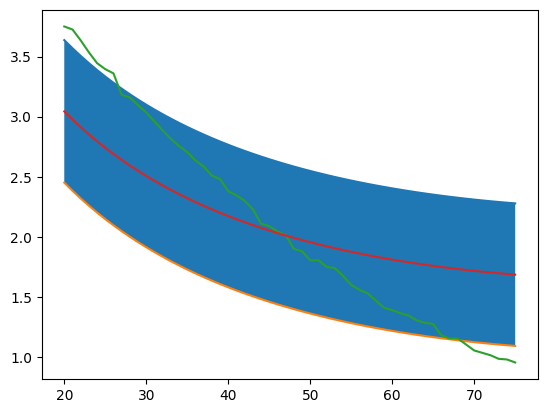

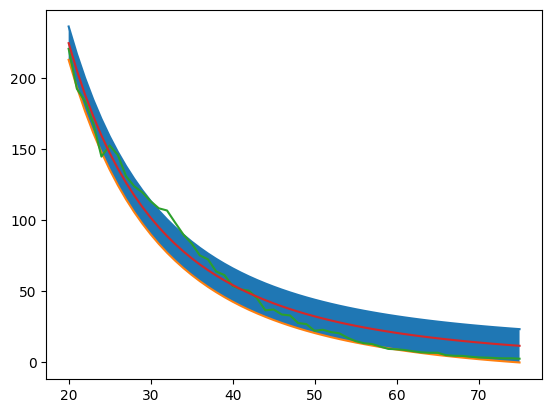

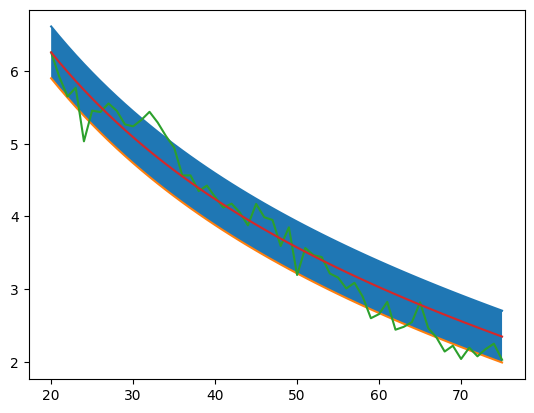

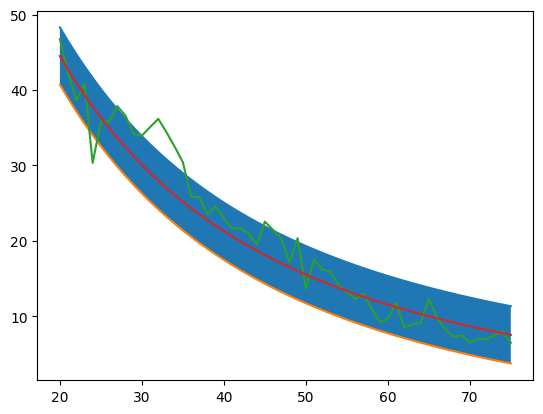

In [20]:

data_mean = out_array[:,0]
data_variance = out_array[:,1]
data_skewness = out_array[:,2]
data_kurtosis = out_array[:,3]

# for i in range(1000):
means = results.mean()[[0,1,2]]
st_devs = results.std()[[0,1,2]]

mean_CI = results.mean()[[3,4,5,6]]
st_devs_CI = results.std()[[3,4,5,6]]

CI_0 = means


values_0 = model.simulate(CI_0, times)
x=np.linspace(20,75,56)

y1=values_0[:,0]+mean_CI[0]+2*st_devs_CI[0]
y2=values_0[:,0]-mean_CI[0]-2*st_devs_CI[0]
plt.plot(x,y1)
plt.plot(x,y2)
plt.fill_between(x,y1,y2)
plt.plot(x,data_mean)
plt.plot(x,values_0[:,0])
plt.show()

y1=values_0[:,1]+mean_CI[1]+2*st_devs_CI[1]
y2=values_0[:,1]-mean_CI[1]-2*st_devs_CI[1]
plt.plot(x,y1)
plt.plot(x,y2)
plt.fill_between(x,y1,y2)
plt.plot(x,data_variance)
plt.plot(x,values_0[:,1])
plt.show()

y1=values_0[:,2]+mean_CI[2]+2*st_devs_CI[2]
y2=values_0[:,2]-mean_CI[2]-2*st_devs_CI[2]
plt.plot(x,y1)
plt.plot(x,y2)
plt.fill_between(x,y1,y2)
plt.plot(x,data_skewness)
plt.plot(x,values_0[:,2])
plt.show()


y1=values_0[:,3]+mean_CI[3]+2*st_devs_CI[3]
y2=values_0[:,3]-mean_CI[3]-2*st_devs_CI[3]
plt.plot(x,y1)
plt.plot(x,y2)
plt.fill_between(x,y1,y2)
plt.plot(x,data_kurtosis)
plt.plot(x,values_0[:,3])
plt.show()
